In [0]:
## Boston Housing Price dataset
## Predict median price of homes in a given Boston suburb in the mid-1970s

# loading the Boston Housing dataset

from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

Using TensorFlow backend.


57344/57026 [==============================] - 0s 0us/step


In [0]:
train_data.shape

(404, 13)

In [0]:
test_data.shape

(102, 13)

In [0]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

In [0]:
## Preparing the data
## Normalizing the data: it would be problematic to feed into a network values that all take widely different ranges.
## A widespread best practice to deal with such data is to do feature-wise normalization
## feature-wise normalization: for each feature in the input data, subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has a unit standard deviation.

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

## NOTE: the quantities (mean and S.D) used for normalizing the test data are computed using the training data. Never use in the workflow any quanity computed on the test data.

In [0]:
## Building the network

## Because of the few sample size, we will use a very small network with two hidden layers, each with 64 units.
## NOTE: lesser the training data implies worse over-fitting. Hence, using a small network is recommended to mitigate over-fitting.

from keras import models, layers

In [0]:
def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model

## Single unit with no-activation = linear layer
## MAE = Mean Absolute Error: absolute value of the difference between predictions and targets

In [0]:
## Validating the approach using K-fold validation
## K-fold validation: used when the sample size is small (if the sample is small, validation score will change a lot depending ie. high variance with regard to the validation split)
## K-fold cross-validation: splitting the available data into K partitions, instantiating K identical models, and training each one on K-1 partitions while evaluating on the remaining partition.

# K-fold validation

import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

In [0]:
# prepare the validation data from partion k

for i in range(k):
  print('processing fold number', i)
  val_data = train_data[i*num_val_samples: (i+1)*num_val_samples]
  val_targets = train_targets[i*num_val_samples: (i+1)*num_val_samples]
  
  # prepare training data from all other partitions
  partial_train_data = np.concatenate([train_data[:i*num_val_samples], train_data[(i+1)*num_val_samples:]], axis=0)
  
  partial_train_targets = np.concatenate([train_targets[:i*num_val_samples], train_targets[(i+1)*num_val_samples:]], axis=0)

processing fold number 0
processing fold number 1
processing fold number 2
processing fold number 3


In [0]:
model = build_model()
model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
all_scores.append(val_mae)

In [0]:
all_scores

[2.4656520999304137, 2.3360297886451873]

In [0]:
# saving the validation logs at each fold

num_epochs = 500
all_mae_histories = []
for i in range(k):
  print('processing fold #', i)
  val_data = train_data[i*num_val_samples:(i+1)*num_val_samples]
  val_targets = train_targets[i*num_val_samples:(i+1)*num_val_samples]
  partial_train_data = np.concatenate([train_data[:i*num_val_samples], train_data[(i+1)*num_val_samples:]], axis=0)
  partial_train_targets = np.concatenate([train_targets[:i*num_val_samples], train_targets[(i+1)*num_val_samples:]], axis=0)
  
model = build_model()
history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0)
mae_history = history.history['val_mean_absolute_error']
all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [0]:
# building the history of successive mean K-fold validation scores

average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

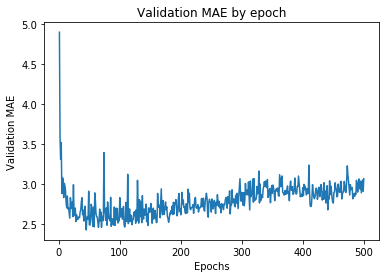

In [0]:
# plotting validation scores

import matplotlib.pyplot as plt

plt.plot(range(1,len(average_mae_history) + 1), average_mae_history)
plt.title('Validation MAE by epoch')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

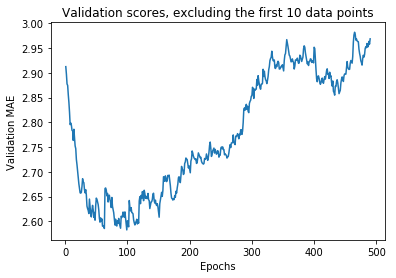

In [0]:
## plotting validation scores, excluding the first 10 data points.
# omit first 10 data points, which are on a different scale than the rest of the curve
# replace each point with an exponential moving average of the previous points, to obtain a smooth curve.

def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous*factor+point*(1-factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1,len(smooth_mae_history) + 1), smooth_mae_history)
plt.title('Validation scores, excluding the first 10 data points')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [0]:
## training the final model
# from above figure, MAE starts significantly increasing after epochs = 80.

model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 1ms/step


In [0]:
test_mae_score

2.4798540227553425